In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline 
import tensorflow as tf
from keras import layers
from keras.applications import ResNet50, ResNet50V2, ResNet101V2
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.optimizers import Adam

In [3]:
batch_size = 8
img_height = 160
img_width = 160
data_dir = "../DFN_dataset/train_20/"
model_name = 'model_9_resnet100v2_dfn_20train_bowser'
model_path = f'./output/models/'

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="training",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names


Found 368 files belonging to 20 classes.
Using 332 files for training.
Found 368 files belonging to 20 classes.
Using 36 files for validation.


In [5]:
AUTO = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTO)
val_ds = val_ds.cache().prefetch(buffer_size=AUTO)

In [6]:
num_classes = len(class_names) 

# Load the pre-trained ResNet50 model (without the top layer)
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model = ResNet50V2(weights='imagenet',include_top=False, input_shape=(img_height, img_width, 3))
# base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width,3))

# Freeze the layers of the pre-trained model
base_model.trainable = False

# build the entire model
x = base_model.output
x = tf.keras.applications.resnet_v2.preprocess_input(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# global average pooling and dense layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 82, 82, 64)   0           ['conv1_conv[0][0]']         

In [7]:
early_stopping = EarlyStopping(monitor="top_k_categorical_accuracy", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience= 5, min_lr = 0.000001)
model.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=[tf.keras.metrics.categorical_accuracy, tf.keras.metrics.top_k_categorical_accuracy])

model_history = model.fit(train_ds, validation_data=val_ds, epochs=300, verbose=1, batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

Epoch 1/300
42/42 [==============================] - 10s 61ms/step - loss: 3.1171 - categorical_accuracy: 0.0361 - top_k_categorical_accuracy: 0.2560 - val_loss: 2.8762 - val_categorical_accuracy: 0.0000e+00 - val_top_k_categorical_accuracy: 0.3889 - lr: 1.0000e-05
Epoch 2/300
42/42 [==============================] - 1s 27ms/step - loss: 2.9231 - categorical_accuracy: 0.0663 - top_k_categorical_accuracy: 0.2711 - val_loss: 2.7754 - val_categorical_accuracy: 0.0000e+00 - val_top_k_categorical_accuracy: 0.3889 - lr: 1.0000e-05
Epoch 3/300
42/42 [==============================] - 1s 23ms/step - loss: 2.8167 - categorical_accuracy: 0.0663 - top_k_categorical_accuracy: 0.2289 - val_loss: 2.7524 - val_categorical_accuracy: 0.0278 - val_top_k_categorical_accuracy: 0.4167 - lr: 1.0000e-05
Epoch 4/300
42/42 [==============================] - 1s 23ms/step - loss: 2.8078 - categorical_accuracy: 0.0452 - top_k_categorical_accuracy: 0.2319 - val_loss: 2.7045 - val_categorical_accuracy: 0.2222 - val

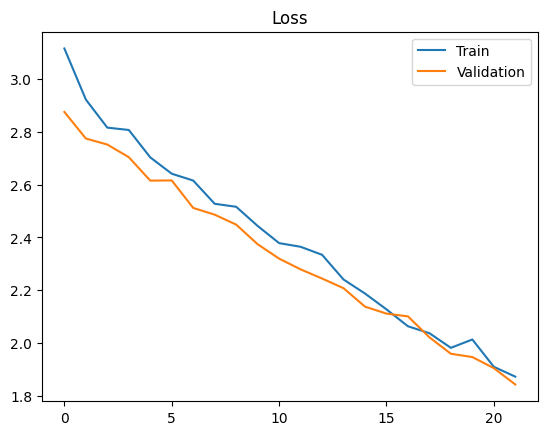

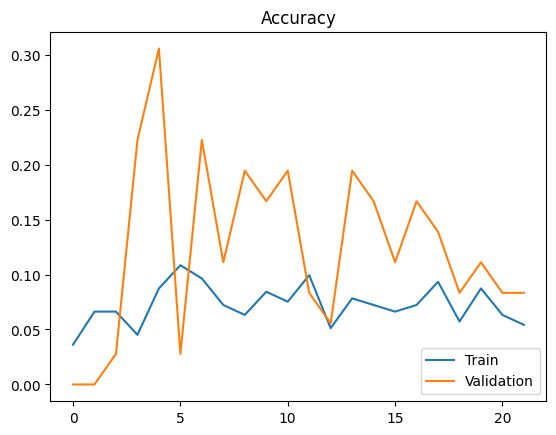

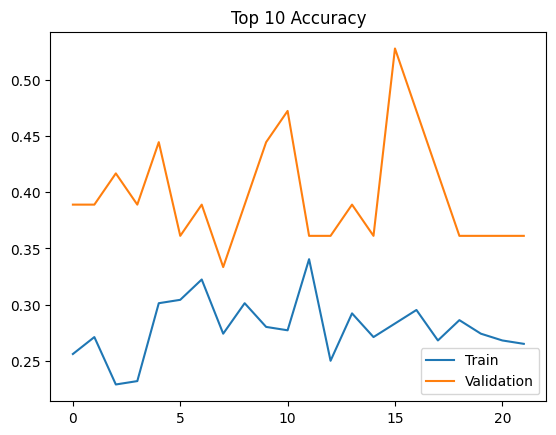

In [8]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

acc_train_curve = model_history.history["categorical_accuracy"]
acc_val_curve = model_history.history["val_categorical_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

top5_acc_train_curve = model_history.history["top_k_categorical_accuracy"]
top5_acc_val_curve = model_history.history["val_top_k_categorical_accuracy"]
plt.plot(top5_acc_train_curve, label = "Train")
plt.plot(top5_acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Top 10 Accuracy") 
plt.show()

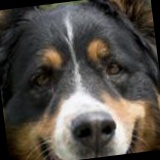

In [23]:
#Testing
# img = tf.keras.preprocessing.image.load_img(path="../photos/dogfacenet10/val/85/85.16.jpg", target_size=(160,160))
img = tf.keras.preprocessing.image.load_img(path="../DFN_dataset/train_20/000002/0002.jpg", target_size=(160,160))
# img = tf.keras.preprocessing.image.load_img("../DFN_dataset/train_100/000051/0008.jpg")
# img = tf.keras.preprocessing.image.load_img("../DFN_dataset/test_200_single_img/Zee.jpg")
# img = tf.keras.preprocessing.image.load_img("../DFN_dataset/bowser_val/signal-2023-11-30-120957_002.jpeg", target_size=(160,160))
img_array = tf.keras.preprocessing.image.img_to_array(img)
# img_array = tf.keras.applications.resnet_v2.preprocess_input(img_array)
img_array = np.array([img_array]) 
# img_array = np.expand_dims(img_array, axis=0)
img


In [24]:
# generate predictions for samples
predictions = model.predict(img_array)

# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)

# get top 10 predictions
top_10_predictions = np.argsort(predictions[0])[:-11:-1]

# top 10 predictions
for i in range(len(top_10_predictions)):
    print("Dog ID:", class_names[top_10_predictions[i]])

1/1 [==============================] - 0s 151ms/step
Dog ID: 000004
Dog ID: 000002
Dog ID: 000009
Dog ID: 000012
Dog ID: 000019
Dog ID: 000016
Dog ID: 000010
Dog ID: 000003
Dog ID: 000007
Dog ID: 000018


In [18]:
# save model and architecture to single file
model.save(model_path + model_name + '.h5')
print(model_path + model_name + '.h5', "Saved model to disk")

./output/models/model_9_resnet100v2_dfn_20train_bowser.h5 Saved model to disk
